## Imports

In [3]:
import os
import glob
import random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import tqdm
from collections import Counter
from scipy.signal import butter, filtfilt
from sklearn.model_selection import GroupKFold
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import layers, models, regularizers, callbacks
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, balanced_accuracy_score

## File loading and configurations

In [56]:
# Cell 2 - Configurations and file loading
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# Edit this to point to your folder containing the CSVs
DATA_DIR = "dataset"               # <- change if needed
FILE_PATTERN = os.path.join(DATA_DIR, "*.csv")  # expecting CSVs; change extension/path if different

# Sampling & windowing
SAMPLING_RATE = 40                 # Hz (given)
WINDOW_SIZE = 64                   # samples (64 @ 40Hz -> 1.6s). Change if desired.
OVERLAP = 0.5                      # 50% overlap
STRIDE = int(WINDOW_SIZE * (1 - OVERLAP))  # sliding step

# Holdout (unseen) contiguous fraction from end of each file
HOLDOUT_FRAC = 0.10                # 10% of each file reserved as final unseen test set

# Grouping for GroupKFold: we split each file into contiguous segments and use those segment IDs as groups
N_SEGMENTS_PER_FILE = 10           # more segments -> finer-grained grouping for GroupKFold

# Cross-validation
N_SPLITS = 5                       # GroupKFold splits

# Training hyperparams
BATCH_SIZE = 64
EPOCHS = 100
LEARNING_RATE = 1e-3

# Model reg / augmentation params
L2_REG = 1e-4
DROPOUT_RATE = 0.3

# Paths
all_files = sorted(glob.glob(FILE_PATTERN))
print("Files found:", all_files)
if len(all_files) == 0:
    raise FileNotFoundError(f"No files found with pattern {FILE_PATTERN}. Place your CSVs in {DATA_DIR}.")

Files found: ['dataset/motor_off.csv', 'dataset/motor_on.csv', 'dataset/motor_on_badfan.csv', 'dataset/motor_on_nofan.csv']


## Pre-processing: windowing, holdout split, grouping, high-pass filter, normalization, augmentation

In [58]:
# Cell 3 - Preprocessing (no custom functions; linear code)
# We'll assume each CSV has columns: ax, ay, az, gx, gy, gz, class_label
CHANNEL_COLS = ['ax', 'ay', 'az', 'gx', 'gy', 'gz']
LABEL_COL = 'class_label'   # numeric 0..3 as you described

# Containers
X_windows = []
y_windows = []
groups = []                 # group id per window for GroupKFold (file_idx * 1000 + seg_id)
file_indices = []           # which source file index the window came from
holdout_X = []
holdout_y = []
holdout_meta = []

for file_idx, file_path in enumerate(all_files):
    print(f"\nProcessing file {file_idx}: {file_path}")
    df = pd.read_csv(file_path)
    # basic checks
    expected_cols = set(CHANNEL_COLS + [LABEL_COL])
    if not expected_cols.issubset(df.columns):
        raise ValueError(f"File {file_path} missing expected columns. Found: {df.columns}")

    n_samples = len(df)
    holdout_start = int(n_samples * (1 - HOLDOUT_FRAC))
    df_train = df.iloc[:holdout_start].reset_index(drop=True)
    df_hold = df.iloc[holdout_start:].reset_index(drop=True)

    # Create contiguous segments for grouping
    segment_length = max(1, len(df_train) // N_SEGMENTS_PER_FILE)

    # Windowing for training part (avoid windows that cross into holdout)
    for start in range(0, len(df_train) - WINDOW_SIZE + 1, STRIDE):
        end = start + WINDOW_SIZE
        window = df_train.loc[start:end-1, CHANNEL_COLS].values.astype(np.float32)  # shape (WINDOW_SIZE, 6)
        # label by center sample to keep label stable
        center_label = int(df_train.loc[start + WINDOW_SIZE//2, LABEL_COL])
        X_windows.append(window)
        y_windows.append(center_label)
        seg_id = (start) // segment_length
        group_id = file_idx * 10000 + seg_id   # file-separated group ids
        groups.append(group_id)
        file_indices.append(file_idx)

    # Create holdout windows (unseen final test)
    for start in range(0, len(df_hold) - WINDOW_SIZE + 1, STRIDE):
        end = start + WINDOW_SIZE
        window = df_hold.loc[start:end-1, CHANNEL_COLS].values.astype(np.float32)
        center_label = int(df_hold.loc[start + WINDOW_SIZE//2, LABEL_COL])
        holdout_X.append(window)
        holdout_y.append(center_label)
        holdout_meta.append({'file_idx': file_idx, 'start_in_hold': start})

# Convert to arrays
X = np.stack(X_windows, axis=0)   # (n_windows, WINDOW_SIZE, 6)
y = np.array(y_windows, dtype=np.int32)
groups = np.array(groups, dtype=np.int32)
file_indices = np.array(file_indices, dtype=np.int32)

holdout_X = np.stack(holdout_X, axis=0) if len(holdout_X) > 0 else np.empty((0, WINDOW_SIZE, len(CHANNEL_COLS)))
holdout_y = np.array(holdout_y, dtype=np.int32)

print(f"\nTotal windows: {X.shape}, labels distribution: {Counter(y)}")
print(f"Holdout windows: {holdout_X.shape}, holdout labels distribution: {Counter(holdout_y)}")


Processing file 0: dataset/motor_off.csv

Processing file 1: dataset/motor_on.csv

Processing file 2: dataset/motor_on_badfan.csv

Processing file 3: dataset/motor_on_nofan.csv

Total windows: (6068, 64, 6), labels distribution: Counter({0: 1517, 1: 1517, 3: 1517, 2: 1517})
Holdout windows: (668, 64, 6), holdout labels distribution: Counter({0: 167, 1: 167, 3: 167, 2: 167})


In [60]:
# Continue preprocessing: high-pass filter to remove DC / drift (Butterworth)
# We'll apply a 2nd-order high-pass with cutoff at 1.0 Hz (adjustable)
HP_CUTOFF = 1.0   # Hz
nyquist = 0.5 * SAMPLING_RATE
wp = HP_CUTOFF / nyquist
b, a = butter(N=2, Wn=wp, btype='highpass', analog=False)

# apply per-window, per-channel with filtfilt to preserve phase
X_filt = np.empty_like(X)
for i in range(X.shape[0]):
    # operate on shape (WINDOW_SIZE, 6)
    w = X[i]
    # apply filter on each channel
    filtered = np.zeros_like(w)
    for ch in range(w.shape[1]):
        filtered[:, ch] = filtfilt(b, a, w[:, ch], padlen=0)
    X_filt[i] = filtered
X = X_filt
del X_filt

if holdout_X.shape[0] > 0:
    holdout_filt = np.empty_like(holdout_X)
    for i in range(holdout_X.shape[0]):
        w = holdout_X[i]
        filtered = np.zeros_like(w)
        for ch in range(w.shape[1]):
            filtered[:, ch] = filtfilt(b, a, w[:, ch], padlen=0)
        holdout_filt[i] = filtered
    holdout_X = holdout_filt
    del holdout_filt

print("High-pass filtering applied (cutoff = {:.2f} Hz)".format(HP_CUTOFF))

High-pass filtering applied (cutoff = 1.00 Hz)


In [62]:
# Normalization: compute per-channel mean/std on training set only
# We compute stats from X (which came from training part of each file)
channel_means = X.reshape(-1, X.shape[-1]).mean(axis=0)
channel_stds = X.reshape(-1, X.shape[-1]).std(axis=0) + 1e-8

print("Channel means:", channel_means)
print("Channel stds: ", channel_stds)

# Apply z-score normalization
X = (X - channel_means[None, None, :]) / channel_stds[None, None, :]
if holdout_X.shape[0] > 0:
    holdout_X = (holdout_X - channel_means[None, None, :]) / channel_stds[None, None, :]

# Keep integer labels as requested (0..3). For training we will convert to one-hot later.
unique, counts = np.unique(y, return_counts=True)
print("Label distribution (train windows):", dict(zip(unique, counts)))
if holdout_X.shape[0] > 0:
    unique_h, counts_h = np.unique(holdout_y, return_counts=True)
    print("Holdout label distribution:", dict(zip(unique_h, counts_h)))

Channel means: [-7.9379452e-06 -1.1322197e-05 -1.8052610e-04 -1.3420491e-03
  4.8552365e-03  5.4218777e-04]
Channel stds:  [ 0.1185135   0.16419429  0.3044338  10.995122    6.6612077   2.1333501 ]
Label distribution (train windows): {0: 1517, 1: 1517, 2: 1517, 3: 1517}
Holdout label distribution: {0: 167, 1: 167, 2: 167, 3: 167}


## Group K-Fold split setup and label encoding for model (one-hot) + class weights

In [65]:
# Cell 4 - Setup GroupKFold and encode labels
gkf = GroupKFold(n_splits=N_SPLITS)

# We'll prepare placeholder lists to capture metrics per fold
fold_histories = []
fold_reports = []
fold_conf_mats = []
fold_val_indices = []

# Compute class weights from training labels (global) to help imbalanced classes
class_labels = np.unique(y)
class_weights_arr = compute_class_weight('balanced', classes=class_labels, y=y)
class_weight_dict = {int(c): float(w) for c, w in zip(class_labels, class_weights_arr)}
print("Class weights (used during fit):", class_weight_dict)

# Convert holdout labels to categorical when needed later
n_classes = len(np.unique(y))
print("Number of classes:", n_classes)

Class weights (used during fit): {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0}
Number of classes: 4


## Model architecture (1D-CNN) and training loop with GroupKFold

In [69]:
# Cell 5 - Training loop: for each fold, build a fresh model, apply augmentations to train data, train, evaluate on val
from tensorflow.keras.utils import to_categorical

fold_idx = 0
val_scores = []

for train_idx, val_idx in gkf.split(X, y, groups=groups):
    print(f"\n=== Fold {fold_idx+1}/{N_SPLITS} ===")
    # Prepare split arrays
    X_train = X[train_idx].copy()
    y_train = y[train_idx].copy()
    X_val = X[val_idx].copy()
    y_val = y[val_idx].copy()

    print("Train shape:", X_train.shape, "Val shape:", X_val.shape)

    # ---------- Augmentation (simple, done by expanding training arrays) ----------
    # We'll create two types of augmentations: (A) additive Gaussian noise, (B) small time shifts (circular)
    AUG_MULTIPLIER = 1   # produce this many augmented copies per original (set 1 -> doubles dataset)
    aug_X_list = [X_train]
    aug_y_list = [y_train]

    for a in range(AUG_MULTIPLIER):
        # Gaussian noise augmentation
        noise = np.random.normal(loc=0.0, scale=0.01, size=X_train.shape).astype(np.float32)
        X_noise = X_train + noise
        aug_X_list.append(X_noise)
        aug_y_list.append(y_train)

        # small amplitude scaling per channel (random within ±10%)
        scales = np.random.uniform(0.9, 1.1, size=(X_train.shape[0], 1, X_train.shape[2])).astype(np.float32)
        X_scaled = X_train * scales
        aug_X_list.append(X_scaled)
        aug_y_list.append(y_train)

        # small circular time shift (roll) of up to +/- 4 samples
        shifts = np.random.randint(-4, 5, size=(X_train.shape[0],))
        X_shifted = np.empty_like(X_train)
        for i_sample in range(X_train.shape[0]):
            s = shifts[i_sample]
            X_shifted[i_sample] = np.roll(X_train[i_sample], shift=s, axis=0)
        aug_X_list.append(X_shifted)
        aug_y_list.append(y_train)

    # Concat augmented sets
    X_train_aug = np.concatenate(aug_X_list, axis=0)
    y_train_aug = np.concatenate(aug_y_list, axis=0)
    # Shuffle
    idxs = np.arange(len(X_train_aug))
    np.random.shuffle(idxs)
    X_train_aug = X_train_aug[idxs]
    y_train_aug = y_train_aug[idxs]

    print("After augmentation, X_train_aug shape:", X_train_aug.shape)

    # One-hot encode labels for Keras
    y_train_cat = to_categorical(y_train_aug, num_classes=n_classes)
    y_val_cat = to_categorical(y_val, num_classes=n_classes)

    # ---------- Build model (1D-CNN) ----------
    # New model per fold
    tf.keras.backend.clear_session()
    model = models.Sequential([
        layers.Input(shape=(WINDOW_SIZE, len(CHANNEL_COLS))),
        layers.Conv1D(32, kernel_size=11, padding='same', kernel_regularizer=regularizers.l2(L2_REG)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling1D(pool_size=2),

        layers.Conv1D(64, kernel_size=9, padding='same', kernel_regularizer=regularizers.l2(L2_REG)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling1D(pool_size=2),

        layers.Conv1D(128, kernel_size=5, padding='same', kernel_regularizer=regularizers.l2(L2_REG)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.GlobalAveragePooling1D(),

        layers.Dropout(DROPOUT_RATE),
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(L2_REG)),
        layers.Dropout(DROPOUT_RATE),
        layers.Dense(n_classes, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    model.summary()

    # Callbacks
    cb_early = callbacks.EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True, verbose=1)
    cb_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, verbose=1, min_lr=1e-6)
    cb_checkpoint = callbacks.ModelCheckpoint(f"best_model_fold{fold_idx}.h5", monitor='val_loss', save_best_only=True, verbose=0)

    # Compute class weights for the augmented train (map from original labels)
    unique_labels, counts_labels = np.unique(y_train_aug, return_counts=True)
    cw = compute_class_weight('balanced', classes=np.arange(n_classes), y=y_train_aug)
    cw_dict = {int(i): float(w) for i, w in enumerate(cw)}
    print("Fold class weights:", cw_dict)

    # Fit
    history = model.fit(
        X_train_aug, y_train_cat,
        validation_data=(X_val, y_val_cat),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[cb_early, cb_lr, cb_checkpoint],
        class_weight=cw_dict,
        verbose=2
    )

    # Save history & fold artifacts
    fold_histories.append(history)
    fold_val_indices.append(val_idx)

    # ---------- Evaluate on validation set ----------
    y_val_pred_prob = model.predict(X_val, verbose=0)
    y_val_pred = np.argmax(y_val_pred_prob, axis=1)

    print("Validation accuracy:", accuracy_score(y_val, y_val_pred))
    print("Validation balanced accuracy:", balanced_accuracy_score(y_val, y_val_pred))
    print("Validation macro F1:", f1_score(y_val, y_val_pred, average='macro'))

    # Confusion matrix & classification report
    cm = confusion_matrix(y_val, y_val_pred, labels=np.arange(n_classes))
    report = classification_report(y_val, y_val_pred, labels=np.arange(n_classes), digits=4, output_dict=True)
    fold_conf_mats.append(cm)
    fold_reports.append(report)

    # keep track of val score
    val_scores.append({
        'fold': fold_idx,
        'accuracy': accuracy_score(y_val, y_val_pred),
        'balanced_accuracy': balanced_accuracy_score(y_val, y_val_pred),
        'macro_f1': f1_score(y_val, y_val_pred, average='macro')
    })

    fold_idx += 1

print("\nCross-validation completed.")
for s in val_scores:
    print(s)


=== Fold 1/5 ===
Train shape: (4854, 64, 6) Val shape: (1214, 64, 6)
After augmentation, X_train_aug shape: (19416, 64, 6)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 64, 32)         │         2,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 64, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 32, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 32, 64)         │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 16, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 16, 128)        │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 16, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,140 (277.89 KB)

 Trainable params: 70,692 (276.14 KB)

 Non-trainable params: 448 (1.75 KB)

Fold class weights: {0: 1.0004122011541632, 1: 1.0004122011541632, 2: 0.889010989010989, 3: 1.1415804327375352}
Epoch 1/100


304/304 - 3s - 11ms/step - accuracy: 0.8730 - loss: 0.3215 - val_accuracy: 0.8756 - val_loss: 0.2944 - learning_rate: 0.0010
Epoch 2/100


304/304 - 2s - 7ms/step - accuracy: 0.9629 - loss: 0.1125 - val_accuracy: 0.9695 - val_loss: 0.2805 - learning_rate: 0.0010
Epoch 3/100
304/304 - 2s - 7ms/step - accuracy: 0.9790 - loss: 0.0762 - val_accuracy: 0.9596 - val_loss: 0.3665 - learning_rate: 0.0010
Epoch 4/100
304/304 - 2s - 7ms/step - accuracy: 0.9861 - loss: 0.0616 - val_accuracy: 0.9819 - val_loss: 0.2834 - learning_rate: 0.0010
Epoch 5/100
304/304 - 2s - 7ms/step - accuracy: 0.9900 - loss: 0.0508 - val_accuracy: 0.9473 - val_loss: 0.4843 - learning_rate: 0.0010
Epoch 6/100
304/304 - 2s - 7ms/step - accuracy: 0.9926 - loss: 0.0444 - val_accuracy: 0.9654 - val_loss: 0.4589 - learning_rate: 0.0010
Epoch 7/100
304/304 - 2s - 7ms/step - accuracy: 0.9930 - loss: 0.0428 - val_accuracy: 0.9819 - val_loss: 0.4256 - learning_rate: 0.0010
Epoch 8/100

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
304/304 - 2s - 8ms/step - accuracy: 0.9952 - loss: 0.0349 - val_accuracy: 0.9794 - val_loss: 0.5869 - learn

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 64, 32)         │         2,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 64, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 32, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 32, 64)         │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 16, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 16, 128)        │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 16, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,140 (277.89 KB)

 Trainable params: 70,692 (276.14 KB)

 Non-trainable params: 448 (1.75 KB)

Fold class weights: {0: 1.0004122011541632, 1: 1.33205268935236, 2: 1.0004122011541632, 3: 0.7999340804218853}
Epoch 1/100


304/304 - 3s - 11ms/step - accuracy: 0.8714 - loss: 0.3183 - val_accuracy: 0.8328 - val_loss: 0.3869 - learning_rate: 0.0010
Epoch 2/100


304/304 - 2s - 8ms/step - accuracy: 0.9693 - loss: 0.1071 - val_accuracy: 0.8962 - val_loss: 0.2870 - learning_rate: 0.0010
Epoch 3/100
304/304 - 2s - 8ms/step - accuracy: 0.9834 - loss: 0.0748 - val_accuracy: 0.8336 - val_loss: 0.5860 - learning_rate: 0.0010
Epoch 4/100


304/304 - 2s - 8ms/step - accuracy: 0.9777 - loss: 0.0935 - val_accuracy: 0.9382 - val_loss: 0.2057 - learning_rate: 0.0010
Epoch 5/100
304/304 - 2s - 7ms/step - accuracy: 0.9900 - loss: 0.0528 - val_accuracy: 0.9234 - val_loss: 0.2689 - learning_rate: 0.0010
Epoch 6/100
304/304 - 2s - 7ms/step - accuracy: 0.9909 - loss: 0.0504 - val_accuracy: 0.9407 - val_loss: 0.2350 - learning_rate: 0.0010
Epoch 7/100
304/304 - 2s - 7ms/step - accuracy: 0.9943 - loss: 0.0415 - val_accuracy: 0.9374 - val_loss: 0.2763 - learning_rate: 0.0010
Epoch 8/100
304/304 - 2s - 8ms/step - accuracy: 0.9954 - loss: 0.0364 - val_accuracy: 0.9053 - val_loss: 0.4912 - learning_rate: 0.0010
Epoch 9/100
304/304 - 2s - 7ms/step - accuracy: 0.9939 - loss: 0.0415 - val_accuracy: 0.9506 - val_loss: 0.2072 - learning_rate: 0.0010
Epoch 10/100

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
304/304 - 2s - 7ms/step - accuracy: 0.9950 - loss: 0.0389 - val_accuracy: 0.9234 - val_loss: 0.3923 - lea

304/304 - 2s - 7ms/step - accuracy: 0.9991 - loss: 0.0233 - val_accuracy: 0.9621 - val_loss: 0.1813 - learning_rate: 5.0000e-04
Epoch 14/100
304/304 - 2s - 7ms/step - accuracy: 0.9997 - loss: 0.0204 - val_accuracy: 0.9481 - val_loss: 0.2853 - learning_rate: 5.0000e-04
Epoch 15/100
304/304 - 2s - 7ms/step - accuracy: 0.9994 - loss: 0.0200 - val_accuracy: 0.8740 - val_loss: 1.0728 - learning_rate: 5.0000e-04
Epoch 16/100
304/304 - 2s - 7ms/step - accuracy: 0.9991 - loss: 0.0200 - val_accuracy: 0.9514 - val_loss: 0.2698 - learning_rate: 5.0000e-04
Epoch 17/100
304/304 - 2s - 7ms/step - accuracy: 0.9973 - loss: 0.0258 - val_accuracy: 0.9448 - val_loss: 0.2836 - learning_rate: 5.0000e-04
Epoch 18/100
304/304 - 2s - 7ms/step - accuracy: 0.9971 - loss: 0.0257 - val_accuracy: 0.8806 - val_loss: 0.7381 - learning_rate: 5.0000e-04
Epoch 19/100

Epoch 19: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
304/304 - 2s - 7ms/step - accuracy: 0.9993 - loss: 0.0193 - val_accuracy: 0.

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true sample

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 64, 32)         │         2,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 64, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 32, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 32, 64)         │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 16, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 16, 128)        │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 16, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,140 (277.89 KB)

 Trainable params: 70,692 (276.14 KB)

 Non-trainable params: 448 (1.75 KB)

Fold class weights: {0: 1.0004122011541632, 1: 0.889010989010989, 2: 0.9995881383855024, 3: 1.1426553672316384}
Epoch 1/100


304/304 - 3s - 11ms/step - accuracy: 0.8491 - loss: 0.3562 - val_accuracy: 0.7405 - val_loss: 2.2479 - learning_rate: 0.0010
Epoch 2/100


304/304 - 2s - 8ms/step - accuracy: 0.9479 - loss: 0.1435 - val_accuracy: 0.7776 - val_loss: 1.8463 - learning_rate: 0.0010
Epoch 3/100


304/304 - 2s - 8ms/step - accuracy: 0.9705 - loss: 0.0993 - val_accuracy: 0.8147 - val_loss: 1.0352 - learning_rate: 0.0010
Epoch 4/100
304/304 - 3s - 8ms/step - accuracy: 0.9830 - loss: 0.0694 - val_accuracy: 0.8171 - val_loss: 1.1146 - learning_rate: 0.0010
Epoch 5/100
304/304 - 2s - 8ms/step - accuracy: 0.9872 - loss: 0.0578 - val_accuracy: 0.7529 - val_loss: 2.5997 - learning_rate: 0.0010
Epoch 6/100
304/304 - 2s - 8ms/step - accuracy: 0.9914 - loss: 0.0477 - val_accuracy: 0.8427 - val_loss: 1.1431 - learning_rate: 0.0010
Epoch 7/100
304/304 - 2s - 8ms/step - accuracy: 0.9904 - loss: 0.0500 - val_accuracy: 0.8163 - val_loss: 1.4658 - learning_rate: 0.0010
Epoch 8/100


304/304 - 2s - 8ms/step - accuracy: 0.9939 - loss: 0.0399 - val_accuracy: 0.9069 - val_loss: 0.4904 - learning_rate: 0.0010
Epoch 9/100
304/304 - 2s - 8ms/step - accuracy: 0.9943 - loss: 0.0377 - val_accuracy: 0.8558 - val_loss: 0.8989 - learning_rate: 0.0010
Epoch 10/100
304/304 - 2s - 8ms/step - accuracy: 0.9937 - loss: 0.0399 - val_accuracy: 0.8921 - val_loss: 0.8302 - learning_rate: 0.0010
Epoch 11/100
304/304 - 2s - 8ms/step - accuracy: 0.9920 - loss: 0.0453 - val_accuracy: 0.7949 - val_loss: 2.0100 - learning_rate: 0.0010
Epoch 12/100
304/304 - 2s - 8ms/step - accuracy: 0.9950 - loss: 0.0358 - val_accuracy: 0.8254 - val_loss: 1.2509 - learning_rate: 0.0010
Epoch 13/100
304/304 - 2s - 8ms/step - accuracy: 0.9976 - loss: 0.0276 - val_accuracy: 0.8484 - val_loss: 1.4348 - learning_rate: 0.0010
Epoch 14/100


304/304 - 2s - 8ms/step - accuracy: 0.9943 - loss: 0.0375 - val_accuracy: 0.9596 - val_loss: 0.1747 - learning_rate: 0.0010
Epoch 15/100
304/304 - 2s - 8ms/step - accuracy: 0.9965 - loss: 0.0295 - val_accuracy: 0.9555 - val_loss: 0.3183 - learning_rate: 0.0010
Epoch 16/100
304/304 - 2s - 8ms/step - accuracy: 0.9968 - loss: 0.0299 - val_accuracy: 0.8896 - val_loss: 0.4495 - learning_rate: 0.0010
Epoch 17/100
304/304 - 2s - 8ms/step - accuracy: 0.9973 - loss: 0.0266 - val_accuracy: 0.8880 - val_loss: 0.4816 - learning_rate: 0.0010
Epoch 18/100
304/304 - 2s - 8ms/step - accuracy: 0.9965 - loss: 0.0278 - val_accuracy: 0.8682 - val_loss: 0.7311 - learning_rate: 0.0010
Epoch 19/100
304/304 - 2s - 8ms/step - accuracy: 0.9965 - loss: 0.0290 - val_accuracy: 0.8048 - val_loss: 4.1922 - learning_rate: 0.0010
Epoch 20/100

Epoch 20: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
304/304 - 2s - 8ms/step - accuracy: 0.9954 - loss: 0.0315 - val_accuracy: 0.9135 - val_loss: 0.5226 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 64, 32)         │         2,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 64, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 32, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 32, 64)         │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 16, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 16, 128)        │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 16, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,140 (277.89 KB)

 Trainable params: 70,692 (276.14 KB)

 Non-trainable params: 448 (1.75 KB)

Fold class weights: {0: 0.8891941391941391, 1: 0.9997940691927513, 2: 1.1418156161806208, 3: 1.0006183017312449}
Epoch 1/100


304/304 - 3s - 11ms/step - accuracy: 0.8882 - loss: 0.2814 - val_accuracy: 0.7246 - val_loss: 1.0392 - learning_rate: 0.0010
Epoch 2/100
304/304 - 2s - 8ms/step - accuracy: 0.9722 - loss: 0.0951 - val_accuracy: 0.8038 - val_loss: 1.4607 - learning_rate: 0.0010
Epoch 3/100
304/304 - 2s - 8ms/step - accuracy: 0.9915 - loss: 0.0505 - val_accuracy: 0.8228 - val_loss: 1.8123 - learning_rate: 0.0010
Epoch 4/100
304/304 - 3s - 8ms/step - accuracy: 0.9960 - loss: 0.0369 - val_accuracy: 0.7848 - val_loss: 1.5478 - learning_rate: 0.0010
Epoch 5/100
304/304 - 2s - 8ms/step - accuracy: 0.9955 - loss: 0.0361 - val_accuracy: 0.8285 - val_loss: 1.6234 - learning_rate: 0.0010
Epoch 6/100
304/304 - 2s - 8ms/step - accuracy: 0.9976 - loss: 0.0302 - val_accuracy: 0.8236 - val_loss: 1.9735 - learning_rate: 0.0010
Epoch 7/100

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
304/304 - 2s - 8ms/step - accuracy: 0.9982 - loss: 0.0266 - val_accuracy: 0.8277 - val_loss: 1.9396 - lear

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 64, 32)         │         2,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 64, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 32, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 32, 64)         │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 16, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 16, 128)        │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 16, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,140 (277.89 KB)

 Trainable params: 70,692 (276.14 KB)

 Non-trainable params: 448 (1.75 KB)

Fold class weights: {0: 1.1407424812030076, 1: 0.8891941391941391, 2: 1.0006183017312449, 3: 1.0006183017312449}
Epoch 1/100


304/304 - 4s - 12ms/step - accuracy: 0.8498 - loss: 0.3391 - val_accuracy: 0.8681 - val_loss: 0.2437 - learning_rate: 0.0010
Epoch 2/100
304/304 - 2s - 8ms/step - accuracy: 0.9555 - loss: 0.1258 - val_accuracy: 0.8887 - val_loss: 0.2634 - learning_rate: 0.0010
Epoch 3/100


304/304 - 2s - 8ms/step - accuracy: 0.9786 - loss: 0.0761 - val_accuracy: 0.9126 - val_loss: 0.2330 - learning_rate: 0.0010
Epoch 4/100
304/304 - 2s - 8ms/step - accuracy: 0.9849 - loss: 0.0612 - val_accuracy: 0.9077 - val_loss: 0.2488 - learning_rate: 0.0010
Epoch 5/100


304/304 - 2s - 8ms/step - accuracy: 0.9883 - loss: 0.0549 - val_accuracy: 0.9876 - val_loss: 0.0542 - learning_rate: 0.0010
Epoch 6/100
304/304 - 2s - 8ms/step - accuracy: 0.9916 - loss: 0.0458 - val_accuracy: 0.9588 - val_loss: 0.1366 - learning_rate: 0.0010
Epoch 7/100
304/304 - 2s - 8ms/step - accuracy: 0.9953 - loss: 0.0368 - val_accuracy: 0.9596 - val_loss: 0.1550 - learning_rate: 0.0010
Epoch 8/100
304/304 - 2s - 8ms/step - accuracy: 0.9934 - loss: 0.0402 - val_accuracy: 0.9621 - val_loss: 0.1225 - learning_rate: 0.0010
Epoch 9/100
304/304 - 2s - 8ms/step - accuracy: 0.9922 - loss: 0.0444 - val_accuracy: 0.9209 - val_loss: 0.3006 - learning_rate: 0.0010
Epoch 10/100


304/304 - 3s - 8ms/step - accuracy: 0.9946 - loss: 0.0374 - val_accuracy: 0.9893 - val_loss: 0.0482 - learning_rate: 0.0010
Epoch 11/100


304/304 - 2s - 8ms/step - accuracy: 0.9951 - loss: 0.0345 - val_accuracy: 0.9934 - val_loss: 0.0380 - learning_rate: 0.0010
Epoch 12/100
304/304 - 2s - 8ms/step - accuracy: 0.9974 - loss: 0.0281 - val_accuracy: 0.9604 - val_loss: 0.1658 - learning_rate: 0.0010
Epoch 13/100
304/304 - 2s - 8ms/step - accuracy: 0.9960 - loss: 0.0314 - val_accuracy: 0.9538 - val_loss: 0.2065 - learning_rate: 0.0010
Epoch 14/100
304/304 - 2s - 8ms/step - accuracy: 0.9958 - loss: 0.0323 - val_accuracy: 0.9678 - val_loss: 0.0951 - learning_rate: 0.0010
Epoch 15/100


304/304 - 2s - 8ms/step - accuracy: 0.9996 - loss: 0.0201 - val_accuracy: 0.9975 - val_loss: 0.0214 - learning_rate: 0.0010
Epoch 16/100
304/304 - 2s - 8ms/step - accuracy: 0.9940 - loss: 0.0363 - val_accuracy: 0.9975 - val_loss: 0.0266 - learning_rate: 0.0010
Epoch 17/100
304/304 - 2s - 8ms/step - accuracy: 0.9984 - loss: 0.0224 - val_accuracy: 0.9934 - val_loss: 0.0278 - learning_rate: 0.0010
Epoch 18/100


304/304 - 2s - 8ms/step - accuracy: 0.9979 - loss: 0.0231 - val_accuracy: 0.9992 - val_loss: 0.0211 - learning_rate: 0.0010
Epoch 19/100
304/304 - 2s - 8ms/step - accuracy: 0.9957 - loss: 0.0311 - val_accuracy: 0.8104 - val_loss: 0.9918 - learning_rate: 0.0010
Epoch 20/100


304/304 - 3s - 8ms/step - accuracy: 0.9975 - loss: 0.0249 - val_accuracy: 0.9984 - val_loss: 0.0202 - learning_rate: 0.0010
Epoch 21/100
304/304 - 2s - 8ms/step - accuracy: 0.9963 - loss: 0.0285 - val_accuracy: 0.8096 - val_loss: 1.0691 - learning_rate: 0.0010
Epoch 22/100
304/304 - 2s - 8ms/step - accuracy: 0.9961 - loss: 0.0307 - val_accuracy: 0.9744 - val_loss: 0.1100 - learning_rate: 0.0010
Epoch 23/100
304/304 - 3s - 8ms/step - accuracy: 0.9985 - loss: 0.0225 - val_accuracy: 0.9860 - val_loss: 0.0502 - learning_rate: 0.0010
Epoch 24/100
304/304 - 3s - 9ms/step - accuracy: 0.9985 - loss: 0.0208 - val_accuracy: 0.9769 - val_loss: 0.1367 - learning_rate: 0.0010
Epoch 25/100
304/304 - 2s - 8ms/step - accuracy: 0.9988 - loss: 0.0194 - val_accuracy: 0.9975 - val_loss: 0.0251 - learning_rate: 0.0010
Epoch 26/100

Epoch 26: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
304/304 - 2s - 8ms/step - accuracy: 0.9968 - loss: 0.0268 - val_accuracy: 0.9876 - val_loss: 0.0417 

304/304 - 2s - 8ms/step - accuracy: 0.9993 - loss: 0.0180 - val_accuracy: 1.0000 - val_loss: 0.0167 - learning_rate: 5.0000e-04
Epoch 28/100
304/304 - 2s - 8ms/step - accuracy: 0.9999 - loss: 0.0154 - val_accuracy: 1.0000 - val_loss: 0.0169 - learning_rate: 5.0000e-04
Epoch 29/100
304/304 - 2s - 8ms/step - accuracy: 0.9999 - loss: 0.0143 - val_accuracy: 0.9959 - val_loss: 0.0199 - learning_rate: 5.0000e-04
Epoch 30/100
304/304 - 3s - 9ms/step - accuracy: 0.9995 - loss: 0.0147 - val_accuracy: 0.9810 - val_loss: 0.0874 - learning_rate: 5.0000e-04
Epoch 31/100
304/304 - 3s - 9ms/step - accuracy: 0.9998 - loss: 0.0130 - val_accuracy: 0.9901 - val_loss: 0.0412 - learning_rate: 5.0000e-04
Epoch 32/100
304/304 - 2s - 8ms/step - accuracy: 0.9998 - loss: 0.0122 - val_accuracy: 0.9843 - val_loss: 0.0548 - learning_rate: 5.0000e-04
Epoch 33/100

Epoch 33: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
304/304 - 2s - 8ms/step - accuracy: 0.9986 - loss: 0.0168 - val_accuracy: 0.

304/304 - 2s - 8ms/step - accuracy: 0.9999 - loss: 0.0110 - val_accuracy: 0.9975 - val_loss: 0.0161 - learning_rate: 2.5000e-04
Epoch 37/100


304/304 - 2s - 8ms/step - accuracy: 0.9997 - loss: 0.0109 - val_accuracy: 0.9984 - val_loss: 0.0146 - learning_rate: 2.5000e-04
Epoch 38/100


304/304 - 2s - 8ms/step - accuracy: 1.0000 - loss: 0.0098 - val_accuracy: 0.9984 - val_loss: 0.0123 - learning_rate: 2.5000e-04
Epoch 39/100
304/304 - 2s - 8ms/step - accuracy: 0.9999 - loss: 0.0094 - val_accuracy: 0.9984 - val_loss: 0.0134 - learning_rate: 2.5000e-04
Epoch 40/100
304/304 - 2s - 8ms/step - accuracy: 1.0000 - loss: 0.0089 - val_accuracy: 0.9942 - val_loss: 0.0172 - learning_rate: 2.5000e-04
Epoch 41/100
304/304 - 2s - 8ms/step - accuracy: 1.0000 - loss: 0.0083 - val_accuracy: 0.9810 - val_loss: 0.1101 - learning_rate: 2.5000e-04
Epoch 42/100
304/304 - 2s - 8ms/step - accuracy: 1.0000 - loss: 0.0079 - val_accuracy: 0.9967 - val_loss: 0.0140 - learning_rate: 2.5000e-04
Epoch 43/100
304/304 - 3s - 9ms/step - accuracy: 1.0000 - loss: 0.0074 - val_accuracy: 0.9942 - val_loss: 0.0163 - learning_rate: 2.5000e-04
Epoch 44/100

Epoch 44: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
304/304 - 2s - 8ms/step - accuracy: 0.9994 - loss: 0.0089 - val_accuracy: 0.

304/304 - 2s - 8ms/step - accuracy: 0.9999 - loss: 0.0071 - val_accuracy: 0.9992 - val_loss: 0.0107 - learning_rate: 1.2500e-04
Epoch 47/100
304/304 - 3s - 9ms/step - accuracy: 1.0000 - loss: 0.0068 - val_accuracy: 0.9959 - val_loss: 0.0142 - learning_rate: 1.2500e-04
Epoch 48/100
304/304 - 2s - 8ms/step - accuracy: 1.0000 - loss: 0.0066 - val_accuracy: 0.9975 - val_loss: 0.0137 - learning_rate: 1.2500e-04
Epoch 49/100
304/304 - 3s - 8ms/step - accuracy: 1.0000 - loss: 0.0063 - val_accuracy: 0.9967 - val_loss: 0.0131 - learning_rate: 1.2500e-04
Epoch 50/100
304/304 - 2s - 8ms/step - accuracy: 1.0000 - loss: 0.0062 - val_accuracy: 0.9951 - val_loss: 0.0132 - learning_rate: 1.2500e-04
Epoch 51/100
304/304 - 2s - 8ms/step - accuracy: 1.0000 - loss: 0.0059 - val_accuracy: 0.9951 - val_loss: 0.0119 - learning_rate: 1.2500e-04
Epoch 52/100


304/304 - 3s - 8ms/step - accuracy: 1.0000 - loss: 0.0057 - val_accuracy: 0.9984 - val_loss: 0.0095 - learning_rate: 1.2500e-04
Epoch 53/100
304/304 - 3s - 8ms/step - accuracy: 0.9998 - loss: 0.0061 - val_accuracy: 0.9835 - val_loss: 0.0782 - learning_rate: 1.2500e-04
Epoch 54/100


304/304 - 2s - 8ms/step - accuracy: 1.0000 - loss: 0.0055 - val_accuracy: 1.0000 - val_loss: 0.0073 - learning_rate: 1.2500e-04
Epoch 55/100
304/304 - 2s - 8ms/step - accuracy: 1.0000 - loss: 0.0053 - val_accuracy: 0.9975 - val_loss: 0.0103 - learning_rate: 1.2500e-04
Epoch 56/100
304/304 - 2s - 8ms/step - accuracy: 1.0000 - loss: 0.0051 - val_accuracy: 0.9967 - val_loss: 0.0110 - learning_rate: 1.2500e-04
Epoch 57/100
304/304 - 2s - 8ms/step - accuracy: 0.9999 - loss: 0.0050 - val_accuracy: 0.9951 - val_loss: 0.0152 - learning_rate: 1.2500e-04
Epoch 58/100
304/304 - 2s - 8ms/step - accuracy: 0.9999 - loss: 0.0052 - val_accuracy: 0.9984 - val_loss: 0.0080 - learning_rate: 1.2500e-04
Epoch 59/100
304/304 - 2s - 8ms/step - accuracy: 1.0000 - loss: 0.0051 - val_accuracy: 0.9975 - val_loss: 0.0085 - learning_rate: 1.2500e-04
Epoch 60/100

Epoch 60: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
304/304 - 2s - 8ms/step - accuracy: 0.9999 - loss: 0.0050 - val_accuracy: 0.9

304/304 - 2s - 8ms/step - accuracy: 1.0000 - loss: 0.0047 - val_accuracy: 0.9992 - val_loss: 0.0065 - learning_rate: 6.2500e-05
Epoch 62/100
304/304 - 3s - 8ms/step - accuracy: 1.0000 - loss: 0.0046 - val_accuracy: 0.9975 - val_loss: 0.0091 - learning_rate: 6.2500e-05
Epoch 63/100
304/304 - 2s - 8ms/step - accuracy: 1.0000 - loss: 0.0045 - val_accuracy: 0.9984 - val_loss: 0.0075 - learning_rate: 6.2500e-05
Epoch 64/100
304/304 - 2s - 8ms/step - accuracy: 1.0000 - loss: 0.0045 - val_accuracy: 0.9975 - val_loss: 0.0082 - learning_rate: 6.2500e-05
Epoch 65/100
304/304 - 2s - 8ms/step - accuracy: 1.0000 - loss: 0.0044 - val_accuracy: 0.9984 - val_loss: 0.0077 - learning_rate: 6.2500e-05
Epoch 66/100
304/304 - 2s - 8ms/step - accuracy: 1.0000 - loss: 0.0044 - val_accuracy: 0.9984 - val_loss: 0.0081 - learning_rate: 6.2500e-05
Epoch 67/100

Epoch 67: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
304/304 - 2s - 8ms/step - accuracy: 1.0000 - loss: 0.0043 - val_accuracy: 0.

## Evaluate ensemble of fold models on holdout (final unseen) and show metrics & plots

Loaded and predicted with best_model_fold0.h5
Loaded and predicted with best_model_fold1.h5


Loaded and predicted with best_model_fold2.h5


Loaded and predicted with best_model_fold3.h5


Loaded and predicted with best_model_fold4.h5

Holdout metrics (ensemble):
Accuracy: 0.7559880239520959
Balanced accuracy: 0.7559880239520959
Macro F1: 0.679703954722487

Classification report (holdout):
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       167
           1     1.0000    1.0000    1.0000       167
           2     1.0000    0.0240    0.0468       167
           3     0.5061    1.0000    0.6720       167

    accuracy                         0.7560       668
   macro avg     0.8765    0.7560    0.6797       668
weighted avg     0.8765    0.7560    0.6797       668



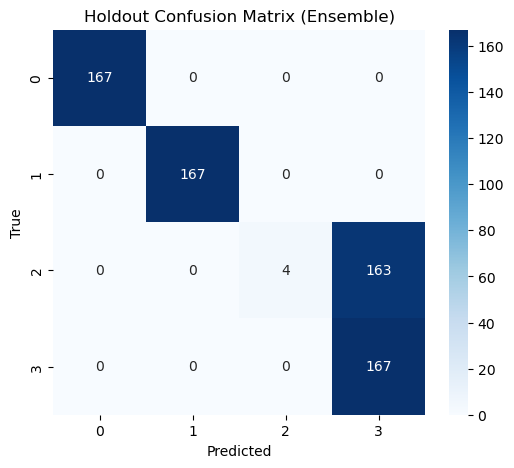

In [83]:
# Cell 6 - Evaluate on holdout set using an ensemble average of fold models (if holdout exists)
if holdout_X.shape[0] == 0:
    print("No holdout data available (HOLDOUT_FRAC may be 0 or file reading issue).")
else:
    # Load predictions from each saved fold model and average probabilities
    preds = []
    for i in range(len(val_scores)):
        model_path = f"best_model_fold{i}.keras"
        if not os.path.exists(model_path):
            print("Model checkpoint missing:", model_path)
            continue
        tf.keras.backend.clear_session()
        m = tf.keras.models.load_model(model_path)
        p = m.predict(holdout_X, verbose=0)   # shape (n_holdout, n_classes)
        preds.append(p)
        print(f"Loaded and predicted with {model_path}")

    if len(preds) == 0:
        raise RuntimeError("No fold models found to evaluate on holdout.")
    preds_mean = np.mean(np.stack(preds, axis=0), axis=0)
    y_hold_pred = np.argmax(preds_mean, axis=1)
    print("\nHoldout metrics (ensemble):")
    print("Accuracy:", accuracy_score(holdout_y, y_hold_pred))
    print("Balanced accuracy:", balanced_accuracy_score(holdout_y, y_hold_pred))
    print("Macro F1:", f1_score(holdout_y, y_hold_pred, average='macro'))
    print("\nClassification report (holdout):")
    print(classification_report(holdout_y, y_hold_pred, digits=4))

    # Confusion matrix heatmap
    cm_hold = confusion_matrix(holdout_y, y_hold_pred, labels=np.arange(n_classes))
    plt.figure(figsize=(6,5))
    sns.heatmap(cm_hold, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(n_classes), yticklabels=np.arange(n_classes))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Holdout Confusion Matrix (Ensemble)")
    plt.show()

## Training curves & per-fold confusion matrices / reports (visualization)

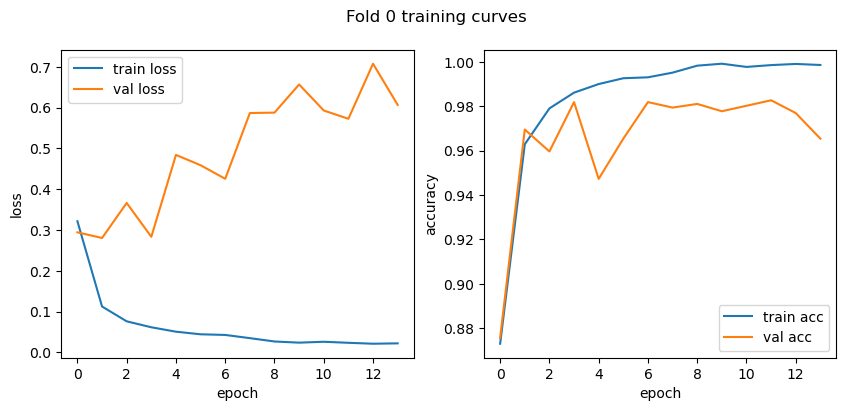

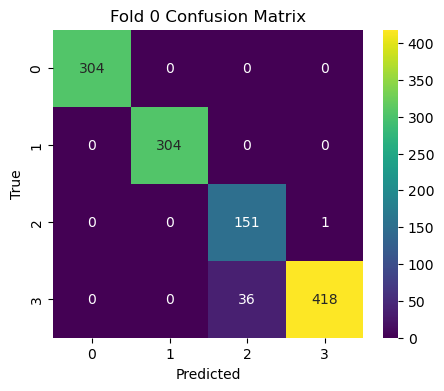

Fold 0 classification report summary (per-class f1):
0 1.0
1 1.0
2 0.8908554572271387
3 0.9576174112256587
Macro avg f1: 0.9621182171131993





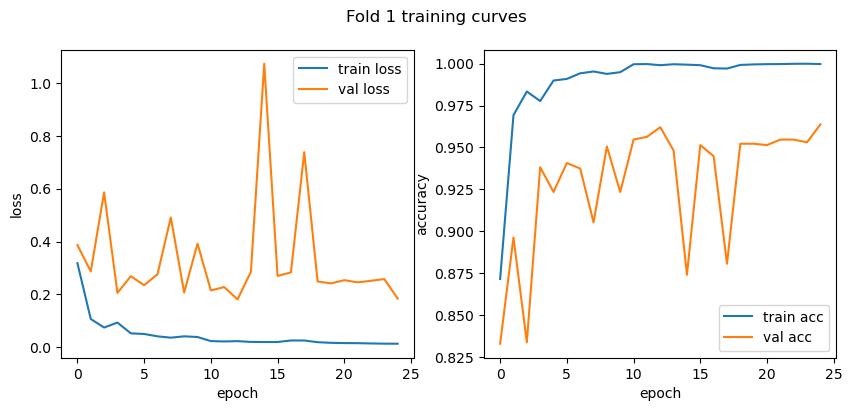

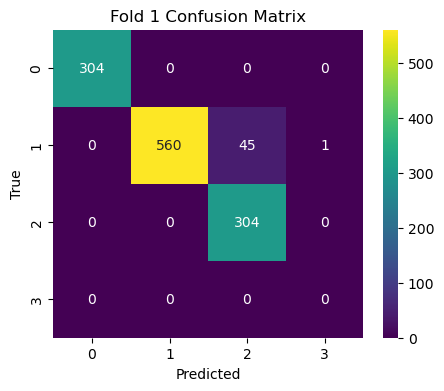

Fold 1 classification report summary (per-class f1):
0 1.0
1 0.9605488850771869
2 0.9310872894333844
3 0.0
Macro avg f1: 0.7229090436276429





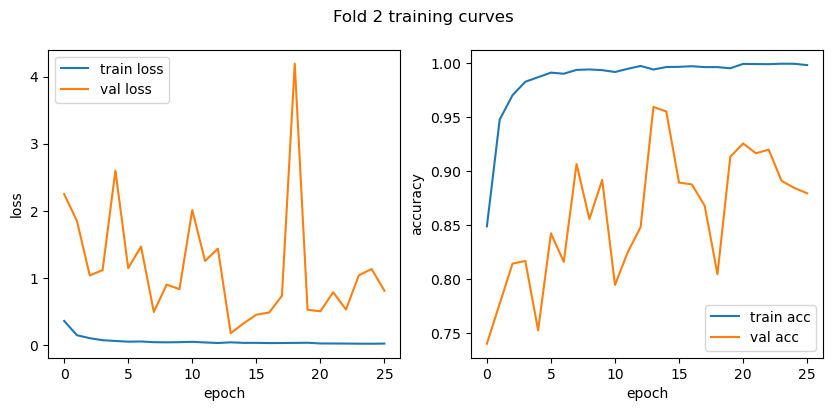

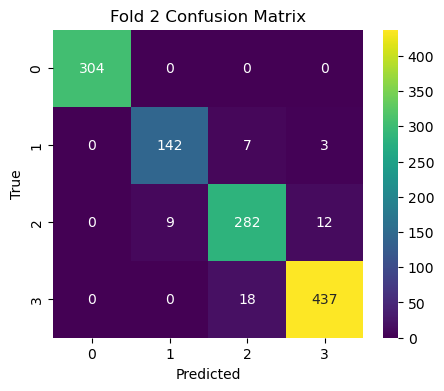

Fold 2 classification report summary (per-class f1):
0 1.0
1 0.9372937293729373
2 0.9245901639344263
3 0.9636163175303197
Macro avg f1: 0.9563750527094209





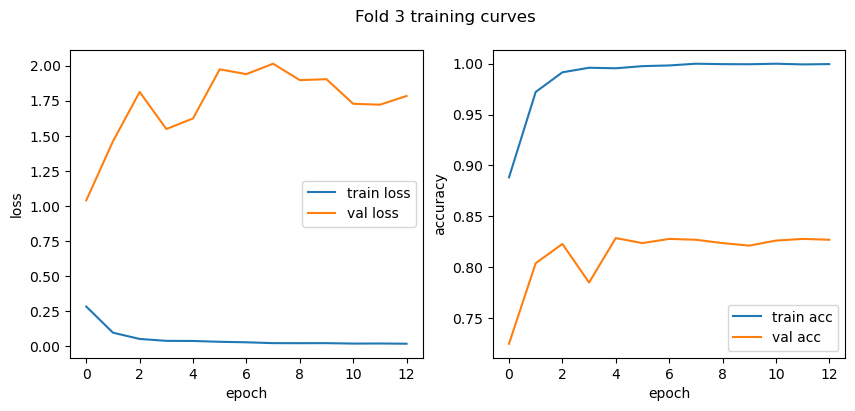

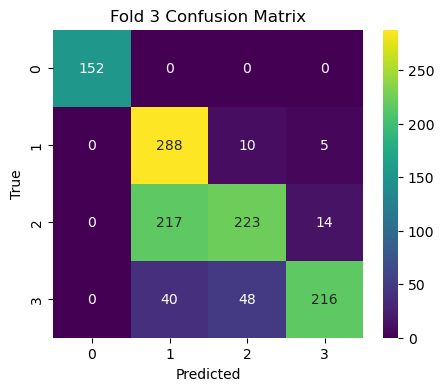

Fold 3 classification report summary (per-class f1):
0 1.0
1 0.6792452830188679
2 0.6068027210884354
3 0.8014842300556586
Macro avg f1: 0.7718830585407404





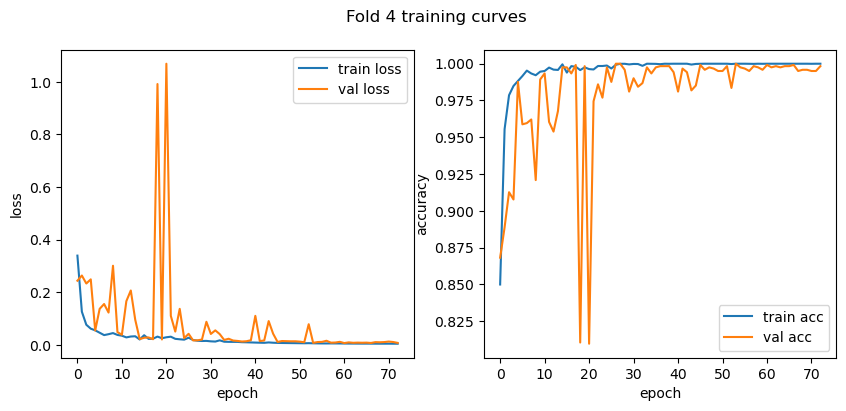

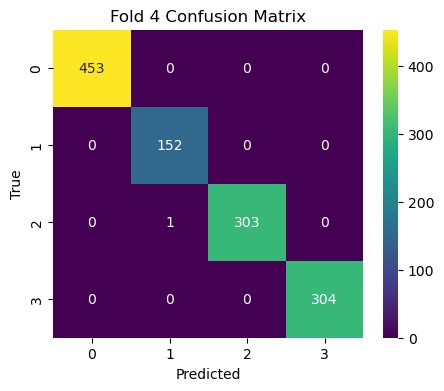

Fold 4 classification report summary (per-class f1):
0 1.0
1 0.9967213114754099
2 0.9983525535420099
3 1.0
Macro avg f1: 0.998768466254355





In [78]:
# Cell 7 - Plot training curves for each fold and show confusions
for i, hist in enumerate(fold_histories):
    plt.figure(figsize=(10,4))
    plt.suptitle(f"Fold {i} training curves")
    plt.subplot(1,2,1)
    plt.plot(hist.history['loss'], label='train loss')
    plt.plot(hist.history['val_loss'], label='val loss')
    plt.xlabel('epoch'); plt.ylabel('loss'); plt.legend()

    plt.subplot(1,2,2)
    plt.plot(hist.history['accuracy'], label='train acc')
    plt.plot(hist.history['val_accuracy'], label='val acc')
    plt.xlabel('epoch'); plt.ylabel('accuracy'); plt.legend()
    plt.show()

    # Confusion matrix for this fold
    cm = fold_conf_mats[i]
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=np.arange(n_classes), yticklabels=np.arange(n_classes))
    plt.title(f"Fold {i} Confusion Matrix")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.show()

    # print classification report (formatted)
    report_dict = fold_reports[i]
    print(f"Fold {i} classification report summary (per-class f1):")
    for cls in sorted([k for k in report_dict.keys() if isinstance(k, (str,)) and k.isdigit()]):
        print(cls, report_dict[cls]['f1-score'])
    # also print macro avg
    if 'macro avg' in report_dict:
        print("Macro avg f1:", report_dict['macro avg']['f1-score'])
    print("\n\n")

## Cell Additional checks (sanity & robustness tests)
### 1) Shuffled-label sanity (quick check) - training on random labels should fail.
### 2) Perturbation test: add noise/axis-rotation on holdout and see drop (robustness).

In [81]:
# Cell 8 - Sanity checks

# 1) Shuffled-label sanity check on a small subset (optional; expensive)
# We'll train quickly for a few epochs on small subset with shuffled labels to see if model memorizes.
run_sanity = False
if run_sanity:
    idx_sample = np.random.choice(len(X), size=min(5000, len(X)), replace=False)
    X_small = X[idx_sample]
    y_small = y[idx_sample].copy()
    np.random.shuffle(y_small)   # break label association

    y_small_cat = tf.keras.utils.to_categorical(y_small, num_classes=n_classes)
    tf.keras.backend.clear_session()
    model_sanity = models.Sequential([
        layers.Input(shape=(WINDOW_SIZE, len(CHANNEL_COLS))),
        layers.Conv1D(32, kernel_size=11, padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.GlobalAveragePooling1D(),
        layers.Dense(n_classes, activation='softmax')
    ])
    model_sanity.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history_s = model_sanity.fit(X_small, y_small_cat, epochs=6, batch_size=64, verbose=2, validation_split=0.2)
    print("Sanity check done — if model accuracy is high (>0.6) on shuffled labels, we have leak/overfitting risk.")

# 2) Perturbation test on holdout: Add stronger noise and evaluate drop
if holdout_X.shape[0] > 0:
    noise_levels = [0.01, 0.05, 0.1]
    for nl in noise_levels:
        X_noisy = holdout_X + np.random.normal(0, nl, size=holdout_X.shape).astype(np.float32)
        preds_noisy = np.argmax(np.mean([tf.keras.models.load_model(f"best_model_fold{i}.h5").predict(X_noisy, verbose=0) 
                                         for i in range(len(val_scores))], axis=0), axis=1)
        acc = accuracy_score(holdout_y, preds_noisy)
        print(f"Noise std {nl:.3f} -> holdout accuracy {acc:.4f}")

Noise std 0.010 -> holdout accuracy 0.7545


Noise std 0.050 -> holdout accuracy 0.7500


Noise std 0.100 -> holdout accuracy 0.7515
